In [ ]:
# El modelo fue entrenado con Python 3.10.6 y lo entrené de forma local.
# Pero estoy poniendo la version de google colab para que sea mas facil de usar xD

In [ ]:
#1. Importar las bibliotecas necesarias

## TensorFlow y Keras:
import tensorflow as tf
from tensorflow.keras import layers, models

## Para dividir en entrenamiento/prueba
from sklearn.model_selection import train_test_split  

# Para visualización y manipulación de datos
import matplotlib.pyplot as plt
import numpy as np

# Para manejar archivos y directorios
import os

# Para buscar archivos según un patrón (ID)
import glob  

# Para manejar imágenes
from PIL import Image

# Siamese  Network
from model import SiameseNetwork


# (Opcional) Desactivar advertencias de oneDNN si se requiere (en este caso, no se desactiva)
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

print(f"Versión de TensorFlow: {tf.__version__}")

Versión de TensorFlow: 2.18.0


In [ ]:
#2. Configuración y carga de datos desde Google Drive (si aplica)

## ---Montar Google Drive en Google Colab o en un entorno local ---
from google.colab import drive
drive.mount('/content/drive')

# --- Configuración para los datos de firma ---
# Ruta base donde se encuentran las imágenes de firmas (las firmas estan en mi Drive)
# Ruta despues de montar Google Drive:
BASE_DATA_DIR = '/content/drive/MyDrive/SIGNATURE/'  # <=== Ruta De Las Firmas en Drive


# --- Nombre de las carpetas que contienen las firmas falsas y verdaderas ---
FORG_FOLDER_NAME = 'full_forg'
ORG_FOLDER_NAME = 'full_org'

# --- Tamaño de entrada normalizado para las imágenes (64x256) ---
IMAGE_HEIGHT = 95
IMAGE_WIDTH = 256
CHANNELS = 1      # Imagen en escala de grises

# --- Tamaño del lote para el entrenamiento ---
BATCH_SIZE = 32
VALIDATION_SPLIT_RATIO = 0.2  # Proporción de datos para validación
SEED = 42  # Semilla para reproducibilidad

# --- Comprobar si BASE_DATA_DIR existe ---
if not os.path.isdir(BASE_DATA_DIR):
    print(f"ERROR: La carpeta BASE_DATA_DIR '{BASE_DATA_DIR}' no existe!")
    print("Por favor revisa la ruta o sube y descomprime los datos.")
    raise FileNotFoundError(f"La carpeta BASE_DATA_DIR '{BASE_DATA_DIR}' no existe.")
else:
    print(f"Usando BASE_DATA_DIR: {BASE_DATA_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando BASE_DATA_DIR: /content/drive/MyDrive/SIGNATURE/


In [ ]:
#3. Recolección de rutas de archivos y extracción de etiquetas

all_image_paths = []
all_writer_ids_str = []  # Guardar ID del autor como cadena de texto

folders_to_scan = [
    os.path.join(BASE_DATA_DIR, FORG_FOLDER_NAME),
    os.path.join(BASE_DATA_DIR, ORG_FOLDER_NAME)
]

print(f"Escaneando carpetas: {folders_to_scan}")

# Buscar todos los archivos de imagen (.png, .tif, .jpg) en las carpetas
for folder_path in folders_to_scan:
    if not os.path.isdir(folder_path):
        print(f"ADVERTENCIA: No se encontró la carpeta {folder_path}. Se omitirá.")
        continue
    image_files = glob.glob(os.path.join(folder_path, '*.png'))
    if not image_files:
        image_files = glob.glob(os.path.join(folder_path, '*.tif'))
    if not image_files:
        image_files = glob.glob(os.path.join(folder_path, '*.jpg'))

    print(f"Se encontraron {len(image_files)} archivos en {folder_path}")

    for img_path in image_files:
        filename = os.path.basename(img_path)
        parts = filename.split('_')
        if len(parts) >= 2:
            # Extraer ID del autor
            writer_id_str = parts[1]
            all_image_paths.append(img_path)
            all_writer_ids_str.append(writer_id_str)
        else:
            print(f"ADVERTENCIA: No se pudo extraer el ID del nombre del archivo: {filename}")

if not all_image_paths:
    print("ERROR: No se encontraron imágenes. Revisa la ruta y la estructura de carpetas.")
    raise FileNotFoundError("No se encontraron imágenes.")
else:
    print(f"Total de imágenes encontradas: {len(all_image_paths)}")
    print(f"Ejemplos de rutas: {all_image_paths[:5]}")
    print(f"Ejemplos de IDs de autores: {all_writer_ids_str[:5]}")


Escaneando carpetas: ['/content/drive/MyDrive/SIGNATURE/full_forg', '/content/drive/MyDrive/SIGNATURE/full_org']
Se encontraron 1320 archivos en /content/drive/MyDrive/SIGNATURE/full_forg
Se encontraron 1392 archivos en /content/drive/MyDrive/SIGNATURE/full_org
Total de imágenes encontradas: 2712
Ejemplos de rutas: ['/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_25_16.png', '/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_20_6.png', '/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_19_12.png', '/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_25_9.png', '/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_36_14.png']
Ejemplos de IDs de autores: ['25', '20', '19', '25', '36']


In [ ]:
#4. Procesamiento de etiquetas y división del conjunto de datos

# Lista ordenada y única de IDs de autores (clases del modelo)
class_names = sorted(list(set(all_writer_ids_str)))
num_classes = len(class_names)

if num_classes == 0:
    print("ERROR: No se encontraron clases (autores). Revisa la extracción de ID.")
    raise ValueError("No se encontraron clases.")
else:
    print(f"Se encontraron {num_classes} clases: {class_names}")

# --- Diccionario para mapear ID del autor (cadena) a etiqueta numérica ---
writer_id_to_int_label = {writer_id: i for i, writer_id in enumerate(class_names)}

# Convertir todos los IDs de autores a etiquetas numéricas
all_labels_int = [writer_id_to_int_label[writer_id] for writer_id in all_writer_ids_str]
print(f"Ejemplo de etiquetas numéricas: {all_labels_int[:5]}")

# --- Dividir en entrenamiento y validación ---
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels_int,
    test_size=VALIDATION_SPLIT_RATIO,
    random_state=SEED,
    stratify=all_labels_int
)

# --- Verificar la división ---
print(f"Número de muestras de entrenamiento: {len(train_paths)}")
print(f"Número de muestras de validación: {len(val_paths)}")


Se encontraron 58 clases: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '6', '7', '8', '9']
Ejemplo de etiquetas numéricas: [17, 12, 10, 17, 29]
Número de muestras de entrenamiento: 2169
Número de muestras de validación: 543


In [ ]:
#5. Función para cargar y preprocesar imágenes

def load_and_preprocess_image(path, label):
    try:
        # Leer imagen desde el archivo
        image_bytes = tf.io.read_file(path)
        # Decodificar a tensor
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        # Redimensionar a 64x256
        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
            image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
            image = tf.image.grayscale_to_rgb(image)

        # Normalizar píxeles a rango [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        return image, label
    except Exception as e:
        print(f"Error al procesar la imagen {path}: {e}")
        return None, label


In [ ]:
#6. Crear datasets con tf.data para entrenamiento y validación

AUTOTUNE = tf.data.AUTOTUNE  # Mover la definición de AUTOTUNE fuera de la función para usarla globalmente

'''
1. AUTOTUNE = tf.data.AUTOTUNE: Permite que TensorFlow ajuste automáticamente el número de hilos paralelos para optimizar el rendimiento del pipeline de datos.
2. tf.data.Dataset.from_tensor_slices: Crea un objeto Dataset a partir de listas de rutas e índices (etiquetas).
3. train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE): Aplica la función load_and_preprocess_image a cada par (ruta, etiqueta) en el dataset. El argumento num_parallel_calls acelera este proceso.
4. train_dataset.filter(lambda x, y: x is not None): Elimina muestras defectuosas durante el mapeo (por ejemplo, si load_and_preprocess_image devuelve None).
5. train_dataset.shuffle(buffer_size=len(train_paths), seed=SEED): (Solo para entrenamiento) Mezcla los datos para evitar que el modelo aprenda el orden. El buffer_size debe ser suficientemente grande.
6. train_dataset.batch(BATCH_SIZE): Agrupa las muestras en lotes (batches).
7. train_dataset.prefetch(buffer_size=AUTOTUNE): Permite que el pipeline prepare por adelantado los siguientes batches mientras el modelo entrena con el actual, reduciendo el tiempo de espera por lectura de datos (I/O).
8. Se repite este proceso para train_dataset y val_dataset.
'''

# --- Dataset de entrenamiento ---
model = SiameseNetwork()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.filter(lambda x, y: x is not None)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths), seed=SEED)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# --- Dataset de validación ---
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.filter(lambda x, y: x is not None)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("Creación del Dataset completada.")


Creación del Dataset completada.


In [ ]:
#7. Crear un modelo secuencial, donde las capas se apilan una tras otra.

'''
▪️ Capa Conv2D (Capa convolucional):
   - Conv2D(32, (3, 3), activation='relu', input_shape=(...)):
     Primera capa convolucional con 32 filtros, cada uno de tamaño 3x3, usando la función de activación ReLU.
     El parámetro input_shape solo se especifica en la primera capa para indicar la forma de entrada.
   - Las siguientes capas Conv2D (con 64 y 128 filtros) aprenden características más complejas progresivamente.

▪️ Capa MaxPooling2D:
   - MaxPooling2D((2, 2)): Reduce las dimensiones espaciales del mapa de características, tomando el valor máximo en una ventana de 2x2.
     Esto reduce la cantidad de parámetros y ayuda a evitar el sobreajuste (overfitting).

▪️ Capa Flatten:
   - Flatten(): Convierte el mapa de características 2D (o 3D) en un vector 1D para pasarlo a las capas densas.

▪️ Capa Dense (Totalmente conectada):
   - Dense(128, activation='relu'): Capa densa con 128 unidades y activación ReLU.

▪️ Capa Dropout:
   - Dropout(0.5): Técnica de regularización que "apaga" aleatoriamente el 50% de las unidades durante el entrenamiento,
     ayudando a evitar el sobreajuste y mejorando la generalización del modelo.

▪️ Capa de salida (Output):
   - Dense(num_classes): Capa de salida con tantas unidades como clases (personas que firman).
     No se usa activación softmax aquí porque la función de pérdida se configurará con `from_logits=True`.
'''

# --- Definición del modelo ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)  # No se necesita activation='softmax' si usamos from_logits=True
])


# --- Imprimir la estructura detallada del modelo (número de capas, parámetros por capa, etc.) ---
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 254, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 30, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,949,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049,402 (11.63 MB)

 Trainable params: 3,049,402 (11.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#8. --- Compilación del modelo ---

'''
1. model.compile(): Configura el proceso de entrenamiento del modelo.
2. optimizer='adam': Se elige el optimizador Adam, una opción popular y eficaz que generalmente no requiere mucha afinación.
3. loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True):
   - SparseCategoricalCrossentropy: Función de pérdida adecuada para clasificación multiclase cuando las etiquetas son enteros (0, 1, 2, ...).
   - from_logits=True: Indica que la salida del modelo son logits (valores sin aplicar softmax). Esto proporciona mayor estabilidad numérica que aplicar softmax manualmente seguido de una pérdida sin `from_logits`.
4. metrics=['accuracy']: Se monitorea la precisión (accuracy) durante el entrenamiento y la evaluación.
'''

# --- Entrenamiento del modelo ---
# --- En esta parte va a demorar mucho, es mejor dejar suspendida la computadora ---
# --- En mi caso duró 31 horas porque solo tengo 8 de Ram y no tengo tarjeta grafica ---

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Compilación del modelo completada.")


Compilación del modelo completada.


In [ ]:
#9. Entrenamiento del modelo
epochs = 10  # Se reduce el número de épocas para pruebas rápidas; luego puedes aumentarlo.

'''
train_dataset: Conjunto de datos de entrenamiento (preparado con tf.data).
validation_data=val_dataset: Conjunto de datos de validación, usado para evaluar el rendimiento del modelo con datos no vistos después de cada época.
epochs=epochs: Número de épocas definido anteriormente.
'''

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Se guarda el historial del entrenamiento (pérdida y precisión en train y val por cada época)



68/68 ━━━━━━━━━━━━━━━━━━━━ 329s 863ms/step - accuracy: 0.0146 - loss: 4.0811 - val_accuracy: 0.0184 - val_loss: 4.0590
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.0161 - loss: 4.0594 - val_accuracy: 0.0166 - val_loss: 4.0491
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.0287 - loss: 4.0210 - val_accuracy: 0.1657 - val_loss: 3.4722
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.1099 - loss: 3.4868 - val_accuracy: 0.3720 - val_loss: 2.6421
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.2166 - loss: 2.9340 - val_accuracy: 0.4807 - val_loss: 2.2041
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.2908 - loss: 2.5248 - val_accuracy: 0.5764 - val_loss: 1.7272
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.3509 - loss: 2.2232 - val_accuracy: 0.6556 - val_loss: 1.4612
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.3948 - loss: 2.0252 - val_accuracy: 0.7053 - v

In [ ]:
#10. Evaluar el modelo una última vez sobre el conjunto de validación; retorna pérdida y precisión.
test_loss, cnn_test_acc = model.evaluate(val_dataset, verbose=2)
print(f"Precisión en el conjunto de validación: {cnn_test_acc:.4f}")

# --- Extraer las métricas del objeto history ---
acc = history.history['accuracy']        # Precisión en entrenamiento
val_acc = history.history['val_accuracy']# Precisión en validación
loss = history.history['loss']           # Pérdida en entrenamiento
val_loss = history.history['val_loss']   # Pérdida en validación

epochs_range = range(epochs)

'''
Usamos matplotlib.pyplot para dibujar dos gráficos:
-> Precisión (accuracy) en entrenamiento y validación a lo largo de las épocas.
-> Pérdida (loss) en entrenamiento y validación a lo largo de las épocas.
'''

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión en entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en validación')
plt.legend(loc='lower right')
plt.title('Precisión en Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en validación')
plt.legend(loc='upper right')
plt.title('Pérdida en Entrenamiento y Validación')

plt.show()


In [ ]:
#11. Guardar el modelo entrenado

# Ruta para guardar el modelo en formato .keras (formato nuevo recomendado)
model_save_path = os.path.join(BASE_DATA_DIR, 'signature_writer_identification_model.keras')

# Guardar el modelo en formato .keras
model.save(model_save_path)
print(f"El modelo ha sido guardado en: {model_save_path}")

# También se puede guardar el modelo en el formato HDF5 (.h5), más antiguo pero aún común
model_save_path_h5 = os.path.join(BASE_DATA_DIR, 'signature_writer_identification_model.h5')
model.save(model_save_path_h5)
print(f"El modelo ha sido guardado en: {model_save_path_h5}")

El modelo ha sido guardado en: /content/drive/MyDrive/SIGNATURE/signature_writer_identification_model.keras
El modelo ha sido guardado en: /content/drive/MyDrive/SIGNATURE/signature_writer_identification_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
La imagen se predice como escrita por: 50 con 1.79% de confianza


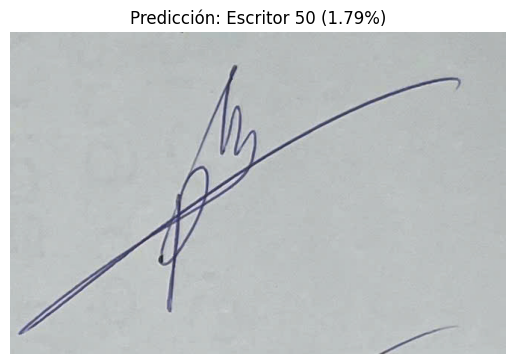

In [ ]:
#12. Cargar el modelo guardado
'''
Esta función es similar a load_and_preprocess_image, pero está adaptada para procesar una única imagen.
Se añade tf.expand_dims para simular un batch de tamaño 1, ya que el modelo espera una entrada en forma de batch.
'''

def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Error al procesar la imagen {image_path} para predicción: {e}")
        return None

# Ruta de la nueva imagen a predecir (¡ajústala según tu caso!)
new_signature_path = '/content/drive/MyDrive/SIGNATURE/full_org/original_58_1.png'


if os.path.exists(new_signature_path):

    # Preprocesar la imagen.
    preprocessed_img_for_pred = preprocess_single_image_for_prediction(new_signature_path)
    if preprocessed_img_for_pred is not None:

        # Obtener predicción del modelo.
        predictions = model.predict(preprocessed_img_for_pred)

        # Aplicar softmax para convertir logits en probabilidades.
        score = tf.nn.softmax(predictions[0])

        # Obtener el índice de la clase con mayor probabilidad.
        predicted_class_index = np.argmax(score)

        # Obtener el ID del escritor correspondiente.
        predicted_writer_id = class_names[predicted_class_index]

        # Calcular el porcentaje de confianza.
        confidence = 100 * np.max(score)

        print(f"La imagen se predice como escrita por: {predicted_writer_id} con {confidence:.2f}% de confianza")

        # Mostrar la imagen junto con el resultado de la predicción.
        img_display = Image.open(new_signature_path)
        plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
        plt.title(f"Predicción: Escritor {predicted_writer_id} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()
else:
    print(f"No se encontró la imagen en: {new_signature_path}")


Se probarán 10 imágenes del conjunto de validación.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Imagen: original_15_23.png
  Etiqueta real: 15
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Imagen: original_41_4.png
  Etiqueta real: 41
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Imagen: forgeries_36_23.png
  Etiqueta real: 36
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Imagen: original_53_17.png
  Etiqueta real: 53
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Imagen: original_51_19.png
  Etiqueta real: 51
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Imagen: forgeries_39_17.png
  Etiqueta real: 39
  Predicción: 50 (Confianza: 1.79%)
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/st

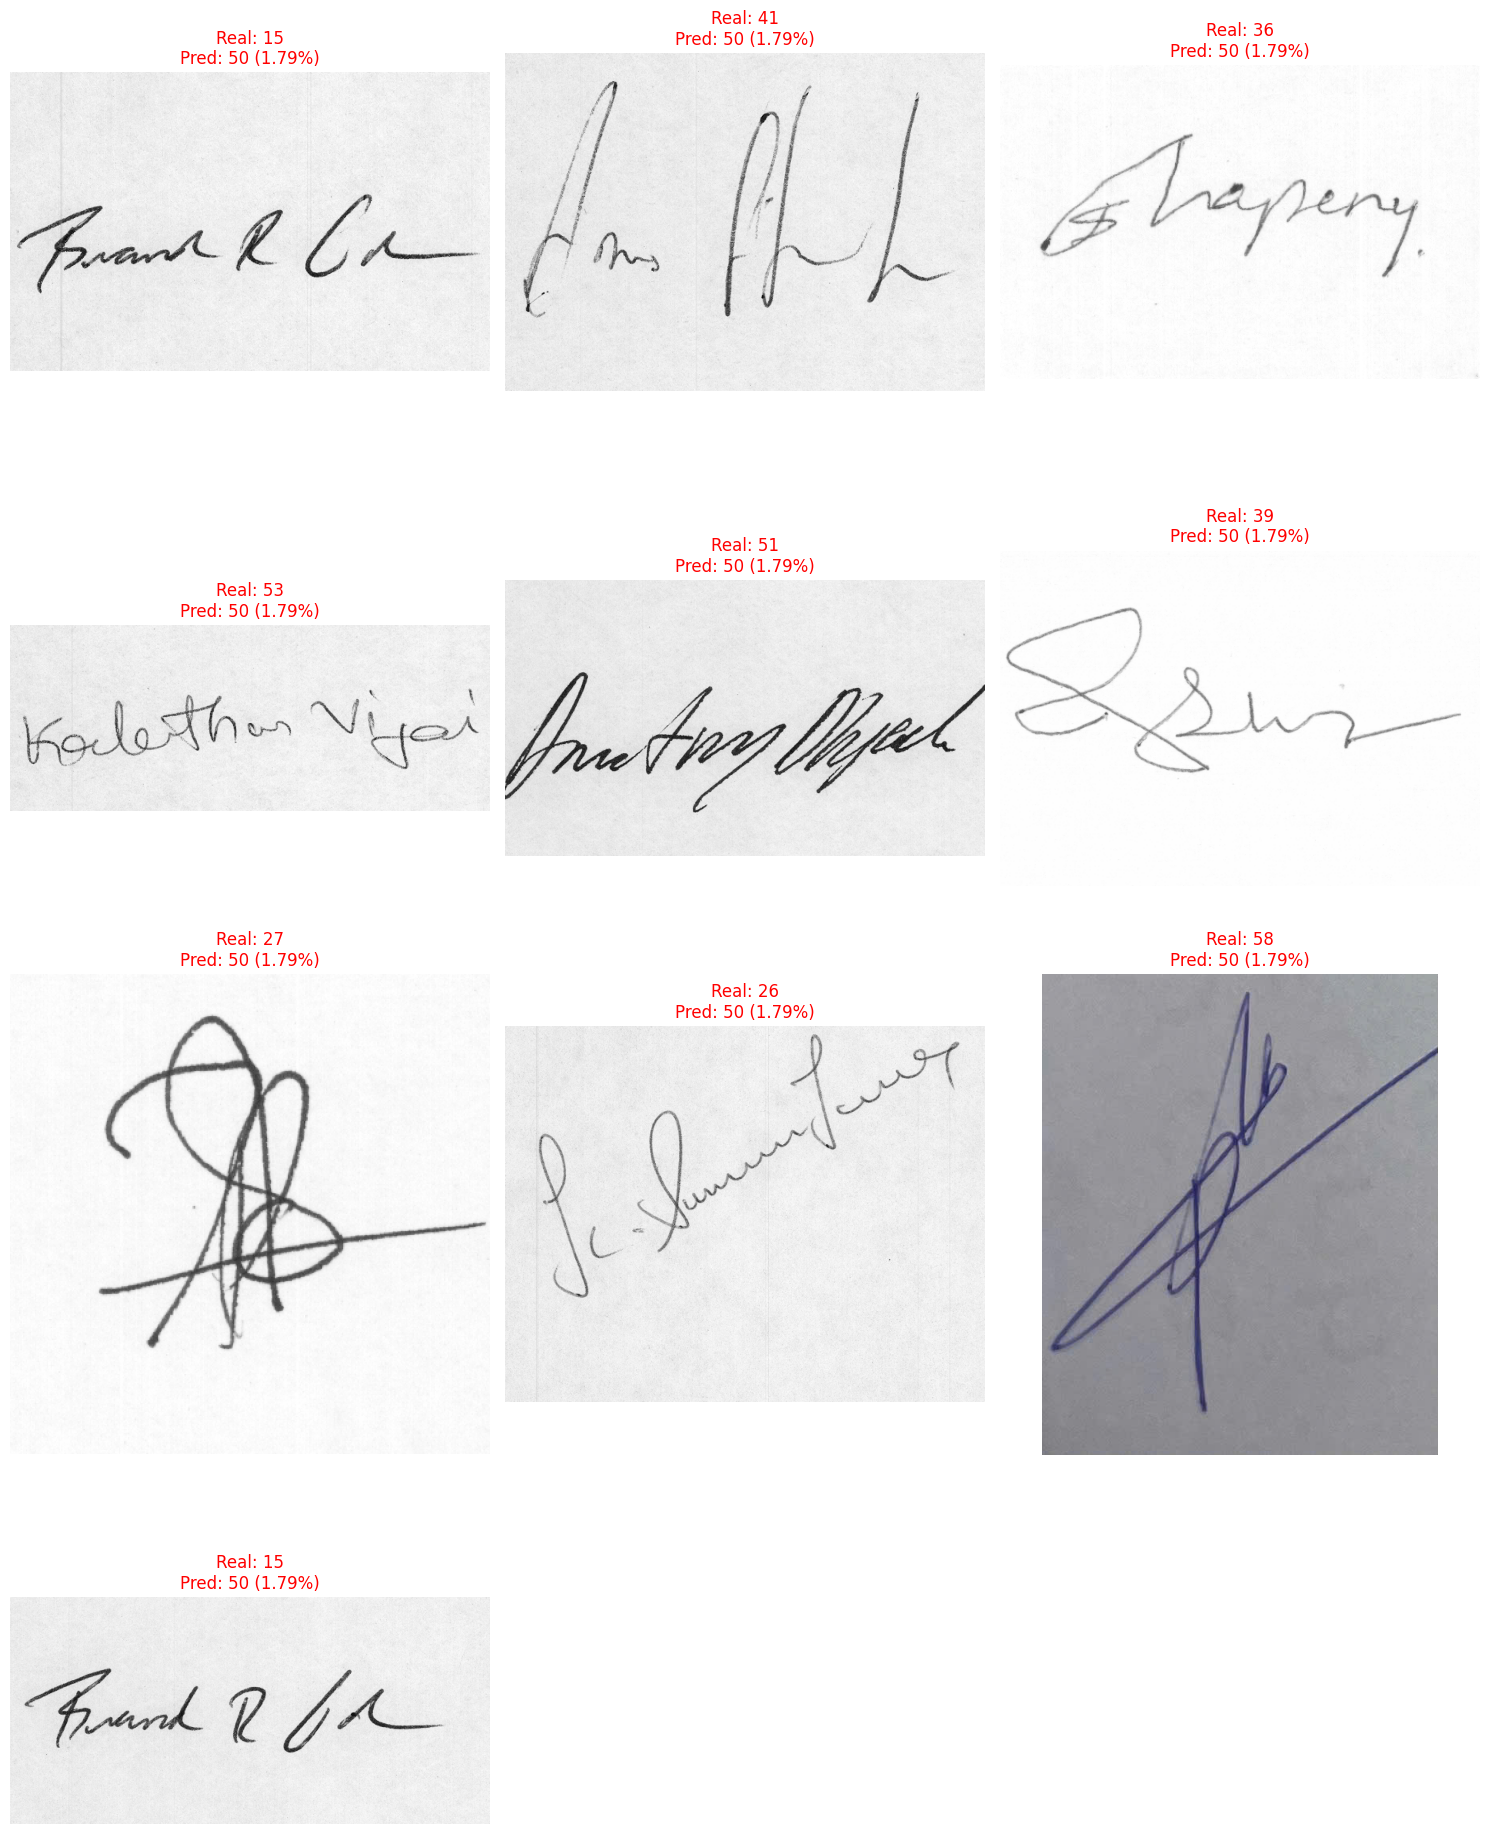

In [ ]:
#13. (Conservamos la función preprocess_single_image_for_prediction)
def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Error al procesar la imagen {image_path} para predicción: {e}")
        return None

test_image_paths = [
    '/content/drive/MyDrive/SIGNATURE/full_org/original_52_1.png',
    '/content/drive/MyDrive/SIGNATURE/full_forg/forgeries_1_10.png',
    # Agrega más rutas aquí
]

if 'val_paths' in locals() and len(val_paths) > 0:
    num_test_samples = min(10, len(val_paths))  # Máximo 10 imágenes

    # np.random.seed(SEED)  # Para tener selección consistente (si deseas)

    test_image_paths_indices = np.random.choice(len(val_paths), num_test_samples, replace=False)
    test_image_paths = [val_paths[i] for i in test_image_paths_indices]
    actual_labels_for_test = [class_names[val_labels[i]] for i in test_image_paths_indices]
    print(f"Se probarán {len(test_image_paths)} imágenes del conjunto de validación.")
else:
    print("No se encontró 'val_paths' o está vacío. Proporcione la lista de imágenes manualmente.")
    test_image_paths = []
    actual_labels_for_test = []

if test_image_paths:
    num_images_to_display = len(test_image_paths)
    cols = 3
    rows = (num_images_to_display + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, image_path in enumerate(test_image_paths):
        if not os.path.exists(image_path):
            print(f"Omitido: No se encontró la imagen en {image_path}")
            continue

        preprocessed_img = preprocess_single_image_for_prediction(image_path)

        if preprocessed_img is not None:
            predictions = model.predict(preprocessed_img)
            score = tf.nn.softmax(predictions[0])
            predicted_class_index = np.argmax(score)
            predicted_writer_id = class_names[predicted_class_index]
            confidence = 100 * np.max(score)

            actual_writer_id = actual_labels_for_test[i] if actual_labels_for_test else "N/A"

            print(f"Imagen: {os.path.basename(image_path)}")
            print(f"  Etiqueta real: {actual_writer_id}")
            print(f"  Predicción: {predicted_writer_id} (Confianza: {confidence:.2f}%)")
            print("-" * 30)

            plt.subplot(rows, cols, i + 1)
            img_display = Image.open(image_path)
            plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
            title_text = f"Real: {actual_writer_id}\nPred: {predicted_writer_id} ({confidence:.2f}%)"

            # Colorea el título: verde si es correcta, rojo si es incorrecta
            title_color = 'green' if actual_writer_id == predicted_writer_id else 'red'
            plt.title(title_text, color=title_color)
            plt.axis('off')
        else:
            print(f"Omitido: No se pudo procesar la imagen {image_path}")

    plt.tight_layout()
    plt.show()
else:
    print("No hay imágenes en 'test_image_paths' para evaluar.")


In [ ]:
#14. Predicción sobre todas las firmas de una persona específica

# (Deja esta función tal como está)
def preprocess_single_image_for_prediction(image_path):
    try:
        image_bytes = tf.io.read_file(image_path)
        try:
            image = tf.image.decode_png(image_bytes, channels=CHANNELS)
        except tf.errors.InvalidArgumentError:
            try:
                image = tf.image.decode_jpeg(image_bytes, channels=CHANNELS)
            except tf.errors.InvalidArgumentError:
                image = tf.image.decode_image(image_bytes, channels=CHANNELS, expand_animations=False)

        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
        if image.shape[-1] != CHANNELS and CHANNELS == 1:
             image = tf.image.rgb_to_grayscale(image)
        elif image.shape[-1] != CHANNELS and CHANNELS == 3 and image.shape[-1] == 1:
             image = tf.image.grayscale_to_rgb(image)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, 0)
    except Exception as e:
        print(f"Error al procesar la imagen {image_path} para predicción: {e}")
        return None

# --- Selecciona el ID de la persona que deseas verificar ---
TARGET_WRITER_ID_STR = '58'  # <<=== CAMBIA ESTE VALOR AL ID DE LA PERSONA (ej: '1', '56', '57', '58')

# --- Filtrar todas las imágenes correspondientes al ID especificado ---
# Asegúrate de que las variables all_image_paths, all_writer_ids_str y class_names estén definidas en celdas anteriores.
if 'all_image_paths' in locals() and 'all_writer_ids_str' in locals() and 'class_names' in locals():
    test_image_paths = []
    actual_labels_for_test = []  # Etiquetas reales (como strings)

    # Verifica si el ID de escritor existe en class_names
    if TARGET_WRITER_ID_STR not in class_names:
        print(f"ERROR: El ID de escritor '{TARGET_WRITER_ID_STR}' no se encuentra en la lista de clases (class_names).")
        print(f"IDs disponibles: {class_names}")
    else:
        for i, writer_id_str_from_list in enumerate(all_writer_ids_str):
            if writer_id_str_from_list == TARGET_WRITER_ID_STR:
                test_image_paths.append(all_image_paths[i])
                actual_labels_for_test.append(writer_id_str_from_list)

        if test_image_paths:
            print(f"Se encontraron {len(test_image_paths)} imágenes del escritor con ID '{TARGET_WRITER_ID_STR}' para verificación.")
            test_image_paths.sort()  # Ordena los archivos para mantener consistencia
        else:
            print(f"No se encontró ninguna imagen del escritor con ID '{TARGET_WRITER_ID_STR}'.")
else:
    print("ERROR: Las variables 'all_image_paths', 'all_writer_ids_str' o 'class_names' no están definidas.")
    print("Ejecuta primero las celdas anteriores para inicializarlas.")
    test_image_paths = []
    actual_labels_for_test = []

# --- Recorrer cada imagen y hacer predicción ---
if test_image_paths:
    num_images_to_display = len(test_image_paths)
    cols = 4  # Puedes aumentar las columnas si hay muchas imágenes
    rows = (num_images_to_display + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows + 1))  # Tamaño de la figura

    correct_predictions = 0

    for i, image_path in enumerate(test_image_paths):
        if not os.path.exists(image_path):
            print(f"Omitido: No se encontró la imagen en {image_path}")
            continue

        preprocessed_img = preprocess_single_image_for_prediction(image_path)

        if preprocessed_img is not None:
            predictions = model.predict(preprocessed_img, verbose=0)
            score = tf.nn.softmax(predictions[0])
            predicted_class_index = np.argmax(score)
            predicted_writer_id = class_names[predicted_class_index]
            confidence = 100 * np.max(score)

            actual_writer_id = actual_labels_for_test[i]

            if actual_writer_id == predicted_writer_id:
                correct_predictions += 1

            # Mostrar imagen con predicción
            plt.subplot(rows, cols, i + 1)
            img_display = Image.open(image_path)
            plt.imshow(img_display, cmap='gray' if CHANNELS == 1 else None)
            title_text = f"Real: {actual_writer_id}\nPred: {predicted_writer_id} ({confidence:.2f}%)"
            title_color = 'green' if actual_writer_id == predicted_writer_id else 'red'
            plt.title(title_text, color=title_color, fontsize=8)
            plt.axis('off')
        else:
            print(f"Omitido: No se pudo procesar la imagen {image_path}")

    overall_accuracy_for_target = (correct_predictions / num_images_to_display) * 100 if num_images_to_display > 0 else 0
    plt.suptitle(f"Predicción para escritor ID: {TARGET_WRITER_ID_STR} - Precisión: {overall_accuracy_for_target:.2f}% ({correct_predictions}/{num_images_to_display})", fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print(f"\nResumen para el escritor ID '{TARGET_WRITER_ID_STR}':")
    print(f"  Total de imágenes evaluadas: {num_images_to_display}")
    print(f"  Predicciones correctas: {correct_predictions}")
    print(f"  Precisión: {overall_accuracy_for_target:.2f}%")

else:
    print(f"No se encontraron imágenes del escritor ID '{TARGET_WRITER_ID_STR}' para evaluar.")
